# Information about the Homework

This notebook will serve as my code and my observations from my code will be noted in my report. I would be using a pre-trained model which has already been implemented in the [Huggingface model Libraries.](https://huggingface.co/models)

I will also be referencing the [Huggingface tutorial on fine tuning](https://huggingface.co/docs/transformers/training) in order to complete the Homework.

In [1]:

! pip install datasets transformers

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [4]:

import transformers

print(transformers.__version__)

4.35.2


In [5]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

#Fine tuning

In [6]:
task = "sst2"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [7]:
from datasets import load_dataset, load_metric

In [8]:

dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-8-c91d69005843>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', task)
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository conte

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [10]:

dataset["train"][0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [11]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def display_sample_entries(target_dataset, sample_count=10):
    assert sample_count <= len(target_dataset), "Can't pick more elements than available in target_dataset."
    random_selections = []
    for _ in range(sample_count):
        random_choice = random.randint(0, len(target_dataset) - 1)
        while random_choice in random_selections:
            random_choice = random.randint(0, len(target_dataset) - 1)
        random_selections.append(random_choice)

    sample_dataframe = pd.DataFrame(target_dataset[random_selections])
    for attribute, attribute_type in target_dataset.features.items():
        if isinstance(attribute_type, datasets.ClassLabel):
            sample_dataframe[attribute] = sample_dataframe[attribute].transform(lambda i: attribute_type.names[i])
    display(HTML(sample_dataframe.to_html()))


In [12]:
display_sample_entries(dataset["test"])

,sentence,label,idx
0,this one 's weaker than most .,positive,1369
1,an enjoyably half-wit remake of the venerable italian comedy big deal on madonna street .,positive,348
2,"shadyac shoots his film like an m. night shyamalan movie , and he frequently maintains the same snail 's pace ; he just forgot to add any genuine tension .",positive,1057
3,a remarkable 179-minute meditation on the nature of revolution .,positive,17
4,"dark , resonant , inventively detailed and packed with fleet turns of plot and a feast of visual amazement .",positive,489
5,"with danilo donati 's witty designs and dante spinotti 's luscious cinematography , this might have made a decent children 's movie -- if only benigni had n't insisted on casting himself in the title role .",positive,62
6,"occasionally , in the course of reviewing art-house obscurities and slam-bam action flicks , a jaded critic smacks into something truly new .",positive,681
7,"the picture , scored by a perversely cheerful marcus miller accordion/harmonica/banjo abomination , is a monument to bad in all its florid variety .",positive,1021
8,"his characters are engaging , intimate and the dialogue is realistic and greatly moving .",positive,1737
9,"it 's a hoot and a half , and a great way for the american people to see what a candidate is like when he 's not giving the same 15-cent stump speech .",positive,1539


In [13]:

metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

In [14]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.59375}

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [16]:

sentence1_key = "sentence"
sentence2_key = None
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: hide new secretions from the parental units 


In [17]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)


In [18]:

encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:

model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [22]:
set_seed(46)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [23]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        self.train_loss=[]
        self.eval_loss=[]
        self.train_acc=[]
        self.eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            self.train_loss.append(train_loss_per_epoch)
            self.train_acc.append(train_acc_per_epoch)


            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for idx, batch_data in enumerate(eval_epoch):
                  batch_data = batch_data.to(device)
                  true_labels = batch_data['labels']
                  with torch.no_grad():
                    model_predictions = model(batch_data['input_ids'])
                    computed_loss = criterion(model_predictions['logits'], true_labels)
                    eval_loss_per_epoch += computed_loss.item()
                    eval_acc_per_epoch += (model_predictions['logits'].argmax(1) == true_labels).sum().item()

            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            self.eval_loss.append(eval_loss_per_epoch)
            self.eval_acc.append(eval_acc_per_epoch)

            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')

        print(f'Time: {(time.time()-start)/60:.3f} minutes')


In [24]:
pip install transformers[torch]

In [25]:
pip install accelerate -U

In [ ]:
import os
os.kill(os.getpid(), 9)

In [25]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir="SandeepBhuiya2001/HW1_model_distilbert-base-uncased-finetuned-sst2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
validation_key = "validation"
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [28]:

trainer.train()

Training Epoch 0:   0%|          | 0/4210 [00:00<?, ?batch/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Evaluation Epoch 0: 100%|██████████| 55/55 [00:01<00:00, 42.86batch/s]


	Train Loss: 0.200 | Train Acc: 92.20%
	Eval Loss: 0.225 | Eval Acc: 89.55%


Evaluation Epoch 1: 100%|██████████| 55/55 [00:01<00:00, 42.26batch/s]


	Train Loss: 0.093 | Train Acc: 96.75%
	Eval Loss: 0.257 | Eval Acc: 89.43%


Evaluation Epoch 2: 100%|██████████| 55/55 [00:01<00:00, 42.30batch/s]


	Train Loss: 0.051 | Train Acc: 98.14%
	Eval Loss: 0.283 | Eval Acc: 89.09%


Evaluation Epoch 3: 100%|██████████| 55/55 [00:01<00:00, 41.91batch/s]


	Train Loss: 0.029 | Train Acc: 98.92%
	Eval Loss: 0.398 | Eval Acc: 87.50%


Evaluation Epoch 4: 100%|██████████| 55/55 [00:01<00:00, 35.04batch/s]

	Train Loss: 0.019 | Train Acc: 99.25%
	Eval Loss: 0.409 | Eval Acc: 88.30%
Time: 24.580 minutes


[0.19988696463372904, 0.09320637200073607, 0.05109763399861955, 0.028834584550946223, 0.018833312575815334]


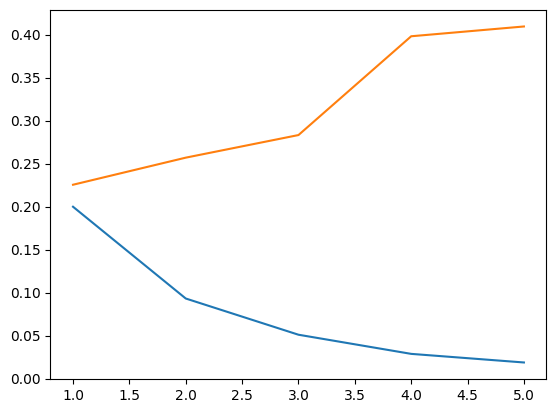

In [29]:
print(trainer.train_loss)
plt.plot([1,2,3,4,5], trainer.train_loss, label='Training Loss')
plt.plot([1,2,3,4,5], trainer.eval_loss, label='Validation Loss')

In [30]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
predictions = pd.DataFrame()
predictions = predictions.append(classifier(encoded_dataset["test"]["sentence"]))

<ipython-input-30-457668f1cfdf>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(classifier(encoded_dataset["test"]["sentence"]))


In [31]:
from transformers.models.transfo_xl.tokenization_transfo_xl import Counter
Counter(dataset["train"]["label"])

Counter({0: 29780, 1: 37569})

In [32]:
text = "The project's results were not up to par, yet there's room for significant enhancement"
text2 = "The performance was average, falling short of my anticipated standards"
text3 = "I found it thoroughly displeasing."
text4 = "It didn't quite appeal to me, though I understand its appeal to some"

In [41]:
#classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
fine_tuned_results = pd.DataFrame()
fine_tuned_results = fine_tuned_results.append(classifier(text))
fine_tuned_results = fine_tuned_results.append(classifier(text2))
fine_tuned_results = fine_tuned_results.append(classifier(text3))
fine_tuned_results = fine_tuned_results.append(classifier(text4))
fine_tuned_results

<ipython-input-41-b6e230cf2844>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fine_tuned_results = fine_tuned_results.append(classifier(text))
<ipython-input-41-b6e230cf2844>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fine_tuned_results = fine_tuned_results.append(classifier(text2))
<ipython-input-41-b6e230cf2844>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fine_tuned_results = fine_tuned_results.append(classifier(text3))
<ipython-input-41-b6e230cf2844>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fine_tuned_results = fine_tuned_results.append(classifier(text4))


,label,score
0,LABEL_1,0.529000
0,LABEL_1,0.516571
0,LABEL_1,0.522064
0,LABEL_1,0.524835


In [42]:
#classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
incorrect_predictions = pd.DataFrame()
count = 10

for eval in dataset['validation']:
    pred = classifier(eval['sentence'])

    if pred[0]['label'] == 'LABEL_1':
        pred[0]['label'] = 1
    else:
        pred[0]['label'] = 0

    if pred[0]['label'] != eval['label']:
        count -= 1
        incorrect_predictions = incorrect_predictions.append(eval, pred)

    if count == 0:
        break
incorrect_predictions

<ipython-input-42-d577c16472e4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incorrect_predictions = incorrect_predictions.append(eval, pred)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-42-d577c16472e4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incorrect_predictions = incorrect_predictions.append(eval, pred)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-42-d577c16472e4>:15: FutureWarning: The frame.append method is deprecated and wil

,sentence,label,idx
0,unflinchingly bleak and desperate,0,1
1,"it 's slow -- very , very slow .",0,4
2,a sometimes tedious film .,0,6
3,or doing last year 's taxes with your ex-wife .,0,7
4,"in exactly 89 minutes , most of which passed a...",0,9
5,it takes a strange kind of laziness to waste t...,0,11
6,... the film suffers from a lack of humor ( so...,0,12
7,even horror fans will most likely not find wha...,0,14
8,... the movie is just a plain old monster .,0,18
9,"in its best moments , resembles a bad high sch...",0,19


In [43]:
vanilla_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)
classifier = pipeline("sentiment-analysis", model=vanilla_model, tokenizer=tokenizer, device=device)

vanilla_results = pd.DataFrame()
vanilla_results = vanilla_results.append(classifier(text))
vanilla_results = vanilla_results.append(classifier(text2))
vanilla_results = vanilla_results.append(classifier(text3))
vanilla_results = vanilla_results.append(classifier(text4))
vanilla_results

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-43-538d7b6be719>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vanilla_results = vanilla_results.append(classifier(text))
<ipython-input-43-538d7b6be719>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vanilla_results = vanilla_results.append(classifier(text2))
<ipython-input-43-538d7b6be719>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vanilla_results = 

,label,score
0,LABEL_1,0.502018
0,LABEL_1,0.513317
0,LABEL_1,0.504969
0,LABEL_0,0.500304


In [44]:
inputs = tokenizer(text, return_tensors="pt").to(device)

In [45]:
with torch.no_grad():
    logits = model(**inputs).logits

In [46]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_0'

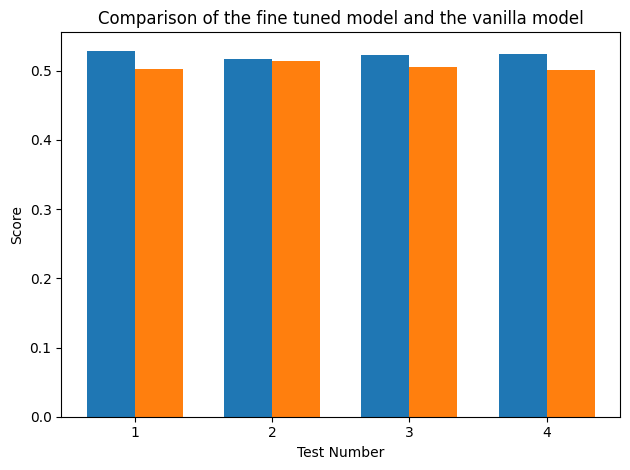

<Figure size 4000x3000 with 0 Axes>

In [47]:
fig, ax = plt.subplots()

labels = ['1','2','3','4']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, fine_tuned_results['score'], width, label='Fine Tuned')
rects2 = ax.bar(x + width/2, vanilla_results['score'], width, label='Vanilla')

# Adding labels and title
ax.set_xlabel("Test Number")
ax.set_ylabel("Score")
ax.set_title("Comparison of the fine tuned model and the vanilla model")
ax.set_xticks(x, labels)
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
plt.figure(figsize=[20,15], dpi=200)
fig.tight_layout()
# Show plot
plt.show()

In [ ]:

!nvidia-smi

Fri Feb  2 21:32:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              31W /  70W |   1623MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
# Assuming 'encoded_dataset["validation"]' is available and properly formatted
validation_dataset = encoded_dataset["validation"]
predictions = classifier(validation_dataset["sentence"])
predicted_labels = [1 if pred['label'] == 'LABEL_1' else 0 for pred in predictions]

# Extract actual labels from the validation dataset
actual_labels = validation_dataset["label"]

# Find indices of incorrect predictions
incorrect_indices = [i for i, (predicted, actual) in enumerate(zip(predicted_labels, actual_labels)) if predicted != actual]

# Select a minimum of ten incorrect samples
min_incorrect_samples = 10
incorrect_samples = [validation_dataset[i] for i in incorrect_indices[:min_incorrect_samples]]

# Display the incorrectly predicted samples with their predicted and actual labels
for sample in incorrect_samples:
    print(f"Sentence: '{sample['sentence']}'")
    print(f"Predicted Label: {'Positive' if predicted_labels[sample['idx']] == 1 else 'Negative'}")
    print(f"Actual Label: {'Positive' if sample['label'] == 1 else 'Negative'}\n")


Sentence: 'it 's a charming and often affecting journey . '
Predicted Label: Negative
Actual Label: Positive

Sentence: 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . '
Predicted Label: Negative
Actual Label: Positive

Sentence: 'the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . '
Predicted Label: Negative
Actual Label: Positive

Sentence: 'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . '
Predicted Label: Negative
Actual Label: Positive

Sentence: 'or doing last year 's taxes with your ex-wife . '
Predicted Label: Positive
Actual Label: Negative

Sentence: 'the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . '
Predicted Label: Negative
Actual Label: Positive

Sentence: '... the film suffers from a lack of humor ( something needed to balance out the vio